In [1]:
import torch

from shap_e.diffusion.sample import sample_latents
from shap_e.diffusion.gaussian_diffusion import diffusion_from_config
from shap_e.models.download import load_model, load_config
from shap_e.util.notebooks import create_pan_cameras, decode_latent_images, gif_widget

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [3]:
xm = load_model('transmitter', device=device)
model = load_model('text300M', device=device)
diffusion = diffusion_from_config(load_config('diffusion'))

/raid/ltnghia02/mxbach_ndphuc/shap-e/shap_e/models/nn/checkpoint.py:32: FutureWarning: `torch.cuda.amp.custom_fwd(args...)` is deprecated. Please use `torch.amp.custom_fwd(args..., device_type='cuda')` instead.
  def forward(ctx, run_function, length, *args):
/raid/ltnghia02/mxbach_ndphuc/shap-e/shap_e/models/nn/checkpoint.py:44: FutureWarning: `torch.cuda.amp.custom_bwd(args...)` is deprecated. Please use `torch.amp.custom_bwd(args..., device_type='cuda')` instead.
  def backward(ctx, *output_grads):
/raid/ltnghia02/mxbach_ndphuc/shap-e/shap_e/models/nn/checkpoint.py:62: FutureWarning: `torch.cuda.amp.custom_fwd(args...)` is deprecated. Please use `torch.amp.custom_fwd(args..., device_type='cuda')` instead.
  def forward(ctx, run_function, length_1, length_2, *args):
/raid/ltnghia02/mxbach_ndphuc/shap-e/shap_e/models/nn/checkpoint.py:87: FutureWarning: `torch.cuda.amp.custom_bwd(args...)` is deprecated. Please use `torch.amp.custom_bwd(args..., device_type='cuda')` instead.
  def back

In [4]:
batch_size = 1
guidance_scale = 15.0
prompt = "a chair"

latents = sample_latents(
    batch_size=batch_size,
    model=model,
    diffusion=diffusion,
    guidance_scale=guidance_scale,
    model_kwargs=dict(texts=[prompt] * batch_size),
    progress=True,
    clip_denoised=True,
    use_fp16=True,
    use_karras=True,
    karras_steps=64,
    sigma_min=1e-3,
    sigma_max=160,
    s_churn=0,
)

  0%|          | 0/64 [00:00<?, ?it/s]

In [8]:
# Example of saving the latents as meshes.
from shap_e.util.notebooks import decode_latent_mesh

for i, latent in enumerate(latents):
    t = decode_latent_mesh(xm, latent).tri_mesh()
    with open(f'chair.obj', 'w') as f:
        t.write_obj(f)

ImportError: /raid/ltnghia02/conda/envs/mirrorgen/lib/python3.9/site-packages/pytorch3d/_C.cpython-39-x86_64-linux-gnu.so: undefined symbol: _ZN3c105ErrorC2ENS_14SourceLocationENSt7__cxx1112basic_stringIcSt11char_traitsIcESaIcEEE

In [58]:
# pip install trimesh
import trimesh
import numpy as np

def make_mirror_frame(
    outer_width=1.0,   # full outer size along X
    outer_height=1.4,  # full outer size along Y
    inner_width=0.8,   # opening size along X
    inner_height=1.2,  # opening size along Y
    thickness=0.02,    # frame thickness along Z
    center_z=0.0,      # center plane of the frame along Z
):
    """
    Create a rectangular mirror frame centered at the origin in XY,
    lying in the XY plane, with thickness along Z.
    Returns a single trimesh.Trimesh.
    """
    # Border widths on each side (must be > 0)
    border_x = (outer_width  - inner_width)  * 0.5
    border_y = (outer_height - inner_height) * 0.5
    if border_x <= 0 or border_y <= 0:
        raise ValueError("inner dimensions must be smaller than outer dimensions.")

    # Convenience: half sizes for placing rails
    half_in_w = inner_width * 0.5
    half_in_h = inner_height * 0.5

    # Rails extents (X, Y, Z)
    # Horizontal rails: full outer width, small height = border_y
    rail_top_extents    = [outer_width, border_y, thickness]
    rail_bottom_extents = [outer_width, border_y, thickness]
    # Vertical rails: small width = border_x, full outer height
    rail_left_extents   = [border_x,   outer_height, thickness]
    rail_right_extents  = [border_x,   outer_height, thickness]

    # Z center for all rails
    zc = center_z

    # Positions so they meet at corners without gaps
    # Top rail center Y = inner_half + border_y/2; bottom is negative
    top_pos    = [0.0,  half_in_h + border_y * 0.5, zc]
    bottom_pos = [0.0, - (half_in_h + border_y * 0.5), zc]
    # Left/right rail center X = inner_half + border_x/2; left negative, right positive
    left_pos   = [ - (half_in_w + border_x * 0.5), 0.0, zc ]
    right_pos  = [   (half_in_w + border_x * 0.5), 0.0, zc ]

    # Create the 4 box rails
    top_rail    = trimesh.creation.box(extents=rail_top_extents)
    bottom_rail = trimesh.creation.box(extents=rail_bottom_extents)
    left_rail   = trimesh.creation.box(extents=rail_left_extents)
    right_rail  = trimesh.creation.box(extents=rail_right_extents)

    # Apply translations
    top_rail.apply_translation(top_pos)
    bottom_rail.apply_translation(bottom_pos)
    left_rail.apply_translation(left_pos)
    right_rail.apply_translation(right_pos)

    # Merge into a single mesh (no boolean ops; just concatenation)
    frame = trimesh.util.concatenate([top_rail, bottom_rail, left_rail, right_rail])

    # Optional: weld coincident vertices/clean tiny artifacts
    frame.merge_vertices()

    # Ensure normals & metadata are sane (optional)
    frame.rezero()       # recenter near origin if tiny drift
    frame.remove_degenerate_faces()
    frame.remove_unreferenced_vertices()

    return frame

frame = make_mirror_frame(
    outer_width=3.0,
    outer_height=3.0,
    inner_width=2.8,
    inner_height=2.8,
    thickness=0.02,
    center_z=0.0,
)
frame.apply_translation(-frame.centroid)
frame.export("mirror_frame.obj")
print("Saved mirror_frame.obj")

Saved mirror_frame.obj


/tmp/ipykernel_3685465/1059275795.py:67: DeprecationWarning: `remove_degenerate_faces` is deprecated and will be removed in March 2024 replace with `self.update_faces(self.nondegenerate_faces(height=height))`
  frame.remove_degenerate_faces()


In [1]:
import os
import torch
import matplotlib.pyplot as plt

# Util function for loading meshes
from pytorch3d.io import load_objs_as_meshes, load_obj

# Data structures and functions for rendering
from pytorch3d.structures import Meshes
from pytorch3d.vis.texture_vis import texturesuv_image_matplotlib
from pytorch3d.renderer import (
    look_at_view_transform,
    FoVPerspectiveCameras, 
    PointLights, 
    DirectionalLights, 
    Materials, 
    RasterizationSettings, 
    MeshRenderer, 
    MeshRasterizer,  
    SoftPhongShader,
    TexturesUV,
    TexturesVertex
)
from pytorch3d.transforms import Transform3d, euler_angles_to_matrix

/raid/ltnghia02/conda/envs/mirrorgen/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/raid/ltnghia02/conda/envs/mirrorgen/lib/python3.9/site-packages/pytorch3d/vis/__init__.py:16: UserWarning: Cannot import plotly-based visualization code. Please install plotly to enable (pip install plotly).
  warnings.warn(


In [2]:
# Setup
if torch.cuda.is_available():
    device = torch.device("cuda:0")
    torch.cuda.set_device(device)
else:
    device = torch.device("cpu")

# Set paths
obj_filename = "object.obj"
mirror_filename = "mirror_frame.obj"

# Load obj file
verts, faces_idx, _ = load_obj(obj_filename)
mirror_verts, mirror_faces_idx, _ = load_obj(mirror_filename)

R = euler_angles_to_matrix(torch.tensor([1.57, 0, 0], device=device), "XYZ")
obj_base_tf = Transform3d(device=device).rotate(R)
mirror_base_tf = Transform3d(device=device)

obj_verts_world_tmp    = obj_base_tf.transform_points(verts.to(device))          # (V,3)
mirror_verts_world_tmp = mirror_base_tf.transform_points(mirror_verts.to(device))# (V,3)

# 3) Compute AABB mins along Y for both meshes
obj_min_y    = obj_verts_world_tmp[:, 1].min()
mirror_min_y = mirror_verts_world_tmp[:, 1].min()

# 4) Translation needed to bottom-align (match mins on Y)
dy = (mirror_min_y - obj_min_y).item()

# 5) Final transforms (optionally, keep any Z offsets you already use)
obj_tf    = obj_base_tf.translate(0.0, dy, -2.0)         # move object up/down to align bottoms
mirror_tf = mirror_base_tf

faces = faces_idx.verts_idx
mirror_faces = mirror_faces_idx.verts_idx

verts_rgb = torch.ones_like(verts)[None]  # (1, V, 3)
textures = TexturesVertex(verts_features=verts_rgb.to(device))

mirror_rgb = torch.ones_like(mirror_verts)[None]
mirror_textures = TexturesVertex(verts_features=mirror_rgb.to(device))


obj_mesh = Meshes(
    verts=[obj_tf.transform_points(verts.to(device))],
    faces=[faces.to(device)],
    textures=textures
)

mirror_mesh = Meshes(
    verts=[mirror_tf.transform_points(mirror_verts.to(device))],
    faces=[mirror_faces.to(device)],
    textures=mirror_textures
)

/raid/ltnghia02/conda/envs/mirrorgen/lib/python3.9/site-packages/pytorch3d/io/obj_io.py:546: UserWarning: No mtl file provided
  warnings.warn("No mtl file provided")


In [3]:
R, T = look_at_view_transform(5.0, 30, 150) 
cameras = FoVPerspectiveCameras(device=device, R=R, T=T)

raster_settings = RasterizationSettings(
    image_size=512, 
    blur_radius=0.0, 
    faces_per_pixel=1,
    bin_size=0
)

lights = PointLights(device=device, location=[[0.0, 0.0, 3.0]])

renderer = MeshRenderer(
    rasterizer=MeshRasterizer(
        cameras=cameras, 
        raster_settings=raster_settings
    ),
    shader=SoftPhongShader(
        device=device, 
        cameras=cameras,
        lights=lights
    )
)

In [4]:
import torch

def reflect_points_across_plane(pts: torch.Tensor, n: torch.Tensor, p: torch.Tensor):
    """
    pts: (V,3) points in world coords
    n:   (3,)  plane normal (need not be unit; we normalize)
    p:   (3,)  a point on the plane
    Returns: (V,3) reflected points
    """
    n = n / (n.norm() + 1e-9)
    v = pts - p
    return pts - 2.0 * (v @ n)[:, None] * n[None, :]

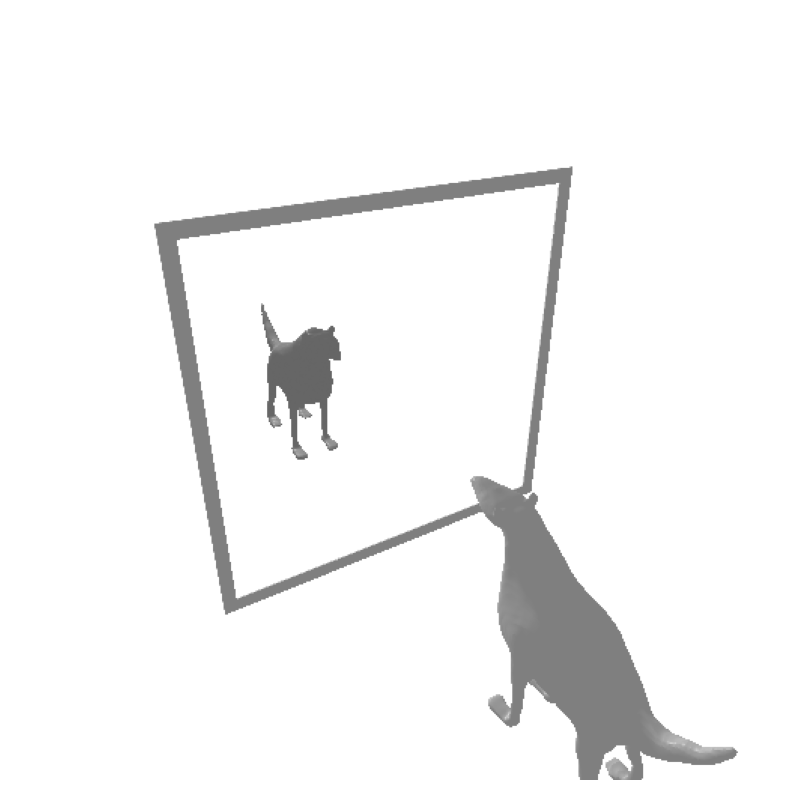

In [5]:
# --- Define your mirror plane ---
# Example: mirror plane is the XY plane at z = z0 (same Z as your frame plane)
z0 = -0.02  # e.g., where you placed the mirror; adjust to your scene
p  = torch.tensor([0.0, 0.0, z0], device=device)
n  = torch.tensor([0.0, 0.0, 1.0], device=device)  # outward normal

# Get the object vertices in world space (the already-transformed ones you render)
obj_verts_world = obj_mesh.verts_list()[0]  # (V,3) on the correct device/dtype
obj_faces       = obj_mesh.faces_list()[0]  # (F,3)

# Reflect vertices across the mirror plane
verts_reflected = reflect_points_across_plane(obj_verts_world, n, p)

# To keep the face winding correct after reflection (normals flip),
# swap two indices per face. This preserves “front face” orientation.
faces_reflected = obj_faces[:, [0, 2, 1]].contiguous()

# Optional: nudge the reflected copy a hair *behind* the mirror plane
# to avoid coplanar z-fighting with any glass quad you might add later.
epsilon = 1e-4
verts_reflected = verts_reflected - epsilon * n

# You can reuse the same textures; many people dim the reflection a bit:
reflected_color = torch.full_like(obj_verts_world, 0.8)  # 80% brightness
reflected_tex   = TexturesVertex(verts_features=reflected_color[None])

reflected_mesh = Meshes(
    verts=[verts_reflected],
    faces=[faces_reflected],
    textures=reflected_tex
)

# Compose the scene: frame, original object, and reflected duplicate
from pytorch3d.structures import join_meshes_as_scene
combined_mesh = join_meshes_as_scene([mirror_mesh, obj_mesh, reflected_mesh])

# Render as before
images = renderer(combined_mesh)
plt.figure(figsize=(10, 10))
plt.imshow(images[0, ..., :3].detach().cpu().numpy())
plt.axis("off");

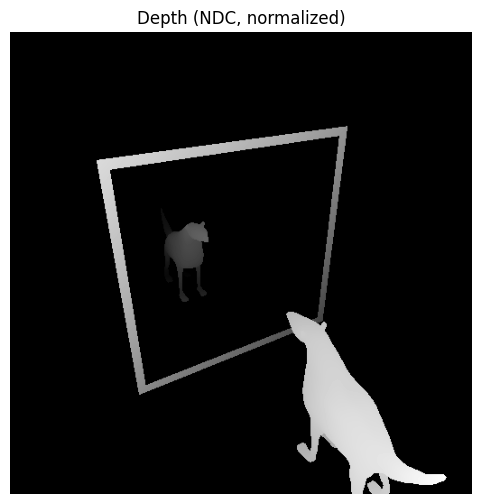

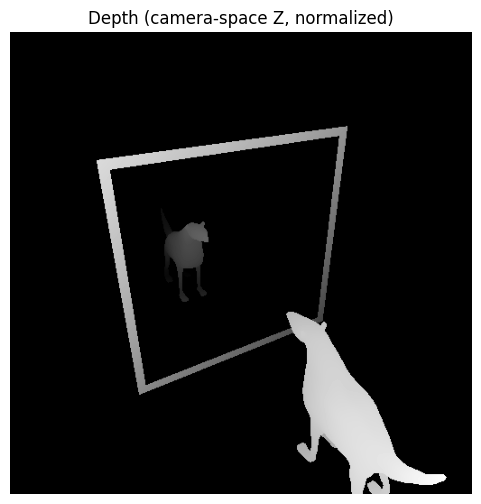

In [6]:
# (Optional) make rasterization robust to heavy geometry to avoid bin overflow warnings
raster_settings = raster_settings.__class__(  # keep your existing values, tweak below as needed
    image_size=raster_settings.image_size,
    blur_radius=raster_settings.blur_radius,
    faces_per_pixel=raster_settings.faces_per_pixel,
    # choose ONE of these strategies:
    # bin_size=0,                         # safest: disable binning (slower)
    max_faces_per_bin=50000              # faster: raise capacity if bins overflow
)

rasterizer = MeshRasterizer(cameras=cameras, raster_settings=raster_settings)

# 1) Rasterize to get fragments (contains zbuf, pix_to_face, etc.)
fragments = rasterizer(combined_mesh)

# 2) Depth in NDC (Near-to-Far). Shape: (N, H, W, K). Take nearest layer k=0.
z_ndc = fragments.zbuf[..., 0]                          # (N, H, W)
pix_to_face = fragments.pix_to_face[..., 0]             # (N, H, W)
valid = pix_to_face >= 0                                # mask of pixels that hit some face

# 3) Visualize NDC depth (nearer -> darker or lighter as you prefer)
depth_vis = z_ndc.clone()
# Fill background with farthest valid depth for nicer visualization
if valid.any():
    far_val = depth_vis[valid].max()
    depth_vis[~valid] = far_val
    # normalize to [0,1] for display; invert so near=white (optional)
    dmin, dmax = depth_vis[valid].min(), depth_vis[valid].max()
    depth_img = (depth_vis - dmin) / (dmax - dmin + 1e-8)
    depth_img = 1.0 - depth_img
else:
    depth_img = torch.zeros_like(depth_vis)

plt.figure(figsize=(6,6))
plt.imshow(depth_img[0].detach().cpu().numpy(), cmap="gray")
plt.title("Depth (NDC, normalized)")
plt.axis("off")
plt.show()

# 4) (Optional) Convert NDC depth -> camera-space Z (metric in the camera frame)
# Build per-pixel NDC x,y grid in [-1, 1]
N, H, W = z_ndc.shape
ys = torch.linspace(1.0, -1.0, H, device=z_ndc.device)  # note flip to match image coords
xs = torch.linspace(-1.0, 1.0, W, device=z_ndc.device)
xv, yv = torch.meshgrid(xs, ys, indexing="xy")          # (W,H) -> we’ll permute

xy_ndc = torch.stack([xv, yv], dim=-1).permute(1,0,2)   # (H,W,2)
# stack x,y with z_ndc
xyz_ndc = torch.cat([xy_ndc[None, ...], z_ndc[..., None]], dim=-1)  # (N,H,W,3)

# Unproject to camera space; take Z
# world_coordinates=False => returns points in the camera coordinate system
cam_pts = cameras.unproject_points(
    xyz_ndc.reshape(N, H*W, 3),
    world_coordinates=False
).reshape(N, H, W, 3)
depth_camZ = cam_pts[..., 2]  # camera-space Z (forward depth)

# Visualize camera-space depth (valid-only normalization)
depth_camZ_vis = depth_camZ.clone()
if valid.any():
    # mask background to far val for display
    far_val = depth_camZ_vis[valid].max()
    depth_camZ_vis[~valid] = far_val
    cmin, cmax = depth_camZ_vis[valid].min(), depth_camZ_vis[valid].max()
    camZ_img = (depth_camZ_vis - cmin) / (cmax - cmin + 1e-8)
    camZ_img = 1.0 - camZ_img
else:
    camZ_img = torch.zeros_like(depth_camZ_vis)

plt.figure(figsize=(6,6))
plt.imshow(camZ_img[0].detach().cpu().numpy(), cmap="gray")
plt.title("Depth (camera-space Z, normalized)")
plt.axis("off")
plt.show()

In [9]:
# Save visualization as PNG
plt.imsave("depth_img.png", camZ_img[0].detach().cpu().numpy(), cmap="gray")

# Save raw camera-space Z (metric) and valid mask for later use
torch.save({"depth_camZ": depth_camZ[0].detach().cpu(),
            "valid": valid[0].cpu()}, "depth_img.pt")

In [6]:
from typing import Iterable, Optional, Sequence, Tuple
import torch
import torch.nn as nn

from pytorch3d.renderer.cameras import CamerasBase
from pytorch3d.structures import Meshes, join_meshes_as_scene
from pytorch3d.renderer import RasterizationSettings, MeshRasterizer


class InstanceIDRenderer(nn.Module):
    """
    Render per-pixel instance IDs for a list of meshes composed into one scene.

    IDs:
      0 -> background
      mesh_to_id[i] (or i+1 if None) -> pixels covered by meshes[i]
    """
    def __init__(
        self,
        cameras: CamerasBase,
        image_size: Tuple[int, int],
        *,
        faces_per_pixel: int = 1,
        blur_radius: float = 1e-7,
        max_faces_per_bin: Optional[int] = None,
        bin_size: Optional[int] = None,
        cull_backfaces: bool = False,
    ) -> None:
        super().__init__()
        self.image_size = image_size
        self.raster_settings = RasterizationSettings(
            image_size=image_size,
            blur_radius=blur_radius,
            faces_per_pixel=faces_per_pixel,
            max_faces_per_bin=max_faces_per_bin,
            bin_size=bin_size,
            cull_backfaces=cull_backfaces,
        )
        self.rasterizer = MeshRasterizer(cameras=cameras, raster_settings=self.raster_settings)

    def to(self, device):
        # Move buffers to device (Cameras in the rasterizer hold device state)
        self.rasterizer = self.rasterizer.to(device)
        return super().to(device)

    @torch.no_grad()
    def forward(
        self,
        meshes: Sequence[Meshes],
        mesh_to_id: Optional[Iterable[int]] = None,
        **kwargs,
    ) -> torch.Tensor:
        """
        Args:
          meshes: list/sequence of Meshes (each can be batch=1 Meshes).
          mesh_to_id: optional iterable of ints (len == len(meshes)).
                      If None, uses 1..len(meshes).

        Returns:
          ids: (N, H, W) int32 per-pixel instance IDs. N is camera batch size.
        """
        assert isinstance(meshes, (list, tuple)) and len(meshes) > 0, "Pass a non-empty list of Meshes."

        # Join into one scene (faces become concatenated in order).
        scene = join_meshes_as_scene(meshes)

        # Build mapping: face_index (packed) -> instance ID
        # face indices of the joined mesh are [0 .. total_faces-1].
        faces_per_mesh = [m.num_faces_per_mesh().sum().item() for m in meshes]
        total_faces = sum(faces_per_mesh)

        if mesh_to_id is None:
            mesh_to_id = list(range(1, len(meshes) + 1))
        else:
            mesh_to_id = list(mesh_to_id)
            assert len(mesh_to_id) == len(meshes), "mesh_to_id length must match meshes."

        # Create mapping vector with a leading 0 for background (so we can index +1 safely).
        # faceid_to_id[k+1] gives the instance ID of packed face k; faceid_to_id[0] = 0 (bg).
        faceid_to_id = torch.empty(total_faces + 1, dtype=torch.int32, device=scene.device if hasattr(scene, 'device') else None)
        faceid_to_id[0] = 0
        cursor = 1
        for fcnt, inst_id in zip(faces_per_mesh, mesh_to_id):
            faceid_to_id[cursor:cursor + fcnt] = int(inst_id)
            cursor += fcnt

        # Rasterize
        fragments = self.rasterizer(scene, **kwargs)  # pix_to_face: (N,H,W,K), -1 for bg
        pix_to_face = fragments.pix_to_face  # (N,H,W,K), int64

        # Choose the closest face per pixel.
        # If faces_per_pixel>1, take the first valid (k where pix_to_face>=0), else k=0.
        if pix_to_face.shape[-1] == 1:
            hit_face = pix_to_face[..., 0]  # (N,H,W)
        else:
            # mask valid faces
            valid = pix_to_face >= 0  # (N,H,W,K)
            # index of first valid along K; if none valid -> keep -1
            # Convert boolean to indices via cumulative max trick
            # fallback: take k=0 then overwrite where no valid
            first_valid = torch.argmax(valid.to(torch.int64), dim=-1)  # (N,H,W), 0 if none valid or first valid at 0
            # gather faces at first_valid
            hit_face = torch.gather(
                pix_to_face,
                dim=-1,
                index=first_valid.unsqueeze(-1)
            ).squeeze(-1)  # (N,H,W)
            # where no valid at all, set -1 explicitly
            none_valid = ~valid.any(dim=-1)
            hit_face[none_valid] = -1

        # Map faces -> instance IDs (shift by +1 to use bg=0 slot)
        # hit_face == -1 -> index 0 (bg)
        ids = faceid_to_id[(hit_face + 1).clamp(min=0)]  # (N,H,W), int32

        return ids

In [15]:
# Assuming you already built: mirror_mesh, obj_mesh, reflected_mesh, cameras, device

inst_renderer = InstanceIDRenderer(
    cameras=cameras,
    image_size=(1024, 1024),
    faces_per_pixel=1,      # or >1 if you want multi-hit robustness
    bin_size=0,             # or set max_faces_per_bin=50000
    cull_backfaces=False
).to(device)

# Assign stable IDs for each mesh in order
# e.g., 1=mirror frame, 2=object, 3=reflection
ids = inst_renderer([mirror_mesh, obj_mesh, reflected_mesh],
                    mesh_to_id=[1, 2, 3])             # (N,H,W) int32
# If your camera batch is 1, take ids[0]
inst_id_img = ids[0]                                   # (H,W), int32 on device

# Save as an 8-bit visualization (purely for viewing):
import matplotlib.pyplot as plt
vis = inst_id_img.detach().cpu().numpy().astype('int32')
plt.imsave("instance_ids.png", vis, cmap="tab20")      # for quick look

# Save the raw IDs (lossless) for training/eval:
torch.save({"instance_ids": inst_id_img.detach().cpu()}, "instance_ids.pt")

In [16]:
import numpy as np
import matplotlib as mpl

def id_color_table(max_id: int,
                   bg_rgb=(0, 0, 0),
                   cmap_name="tab20") -> np.ndarray:
    """
    Returns an array of shape (max_id+1, 3) with uint8 RGB colors.
      index 0 -> background color
      index k -> color for ID k
    """
    # Take the 20 discrete colors from tab20
    base = mpl.cm.get_cmap(cmap_name).colors  # length 20, float in [0,1]
    base = (np.array(base) * 255).astype(np.uint8)  # to 0-255 uint8

    table = np.zeros((max_id + 1, 3), dtype=np.uint8)
    table[0] = np.array(bg_rgb, dtype=np.uint8)      # background
    for k in range(1, max_id + 1):
        table[k] = base[(k - 1) % len(base)]         # wrap if >20 IDs
    return table

# Example: build mapping and list colors actually used in your image
vis = inst_id_img.detach().cpu().numpy().astype(np.int32)  # (H,W)
palette = id_color_table(max_id=int(vis.max()), bg_rgb=(0,0,0))

# Dictionary: {id: (R,G,B)}
id_to_rgb = {int(k): tuple(map(int, palette[k])) for k in np.unique(vis)}
print(id_to_rgb)


{0: (0, 0, 0), 1: (31, 119, 180), 2: (174, 199, 232), 3: (255, 127, 14)}


/tmp/ipykernel_961023/2049753135.py:13: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  base = mpl.cm.get_cmap(cmap_name).colors  # length 20, float in [0,1]


In [17]:
from PIL import Image
import json
import numpy as np

# --- Inputs assumed already defined upstream ---
# vis:            (H, W) int32 instance ID map (0 = background)
# palette:        np.ndarray of shape (max_id+1, 3), dtype=uint8 (palette[k] = RGB for ID k)
# id_to_rgb:      {id: (R, G, B)} mapping derived from palette, e.g. {k: tuple(palette[k]) for k in np.unique(vis)}
# NOTE: These should be built from the SAME palette you used to colorize the mask.

# 1) Save a strict RGB segmentation image (no Matplotlib colormap)
rgb = palette[vis]  # (H, W, 3) uint8
Image.fromarray(rgb, mode="RGB").save("instance_ids_rgb.png")

# 2) Define human-readable text for each instance ID (customize as needed)
#    Provide texts only for the NON-BACKGROUND ids you expect; others will get a generic fallback.
segment_texts = {
    1: "The mirror frame surrounding the reflective surface.",
    2: "The real dog standing in front of the mirror.",
    3: "The dog's reflection visible inside the mirror."
}

# 3) Build the targeted JSON structure
output_json = {
    "caption": "A photo of a dog and its reflection in the mirror. The dog stands close to the mirror in soft indoor light, and its reflection appears clearly on the glass within a simple frame. The background is gently out of focus, drawing attention to the dog and the mirrored image.",
    "seed": 53,
    "segments_info": []
}

# Sort unique IDs and skip background (0)
unique_ids = sorted(int(k) for k in np.unique(vis) if int(k) != 0)

for inst_id in unique_ids:
    # Use the EXACT RGB used to render the RGB mask
    if inst_id in id_to_rgb:
        color_rgb = list(map(int, id_to_rgb[inst_id]))
    else:
        # Fallback to palette table if not present in dict
        color_rgb = list(map(int, palette[inst_id].tolist()))

    text = segment_texts.get(inst_id, f"Object with instance ID {inst_id}.")
    output_json["segments_info"].append({
        "color": color_rgb,   # [R, G, B]
        "text": text
    })

print(output_json)
# 4) Save the targeted JSON
with open("instance_id_colors.json", "w") as f:
    json.dump(output_json, f, indent=2)

print("Saved instance_ids_rgb.png and instance_id_colors.json")

# 5) (Optional) Sanity check: ensure that for each ID, at least one pixel matches the palette color in the saved RGB
#    This helps catch channel-order or palette mismatches early.
for inst_id in unique_ids:
    # find one pixel of this ID
    ys, xs = np.where(vis == inst_id)
    if ys.size > 0:
        y0, x0 = int(ys[0]), int(xs[0])
        assert (rgb[y0, x0] == np.array(palette[inst_id], dtype=np.uint8)).all(), \
            f"Color mismatch for ID {inst_id}: rgb[{y0},{x0}] != palette[{inst_id}]"


{'caption': 'A photo of a dog and its reflection in the mirror. The dog stands close to the mirror in soft indoor light, and its reflection appears clearly on the glass within a simple frame. The background is gently out of focus, drawing attention to the dog and the mirrored image.', 'seed': 53, 'segments_info': [{'color': [31, 119, 180], 'text': 'The mirror frame surrounding the reflective surface.'}, {'color': [174, 199, 232], 'text': 'The real dog standing in front of the mirror.'}, {'color': [255, 127, 14], 'text': "The dog's reflection visible inside the mirror."}]}
Saved instance_ids_rgb.png and instance_id_colors.json
